Curriculum Temperature for Knowledge Distillation

Research Paper: https://arxiv.org/abs/2211.16231

2022

The concept is based off of the classic knowledge distillation - but need more research

Code Link: https://github.com/zhengli97/CTKD

### Simplified Version

In [1]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from data.data_loader import load_cifar10

train_loader, test_loader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [14]:
teacher = models.resnet34(pretrained=True).to(device)
student = models.resnet18(pretrained=False).to(device)

# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')

criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.001)
student_optimizer = optim.Adam(student.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=20)  # adjust T_max as per epochs



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
################ INPUT ################
initial_temperature = 20.0
alpha = 0.9
epochs = 20
#######################################


In [15]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

In [16]:
def knowledge_distillation_loss(outputs, labels, teacher_outputs, temp, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/temp, dim=1),
                                               F.softmax(teacher_outputs/temp, dim=1)) * (alpha * temp * temp) + \
           F.cross_entropy(outputs, labels) * (1. - alpha)


In [8]:
# # Train the teacher model
# for epoch in range(epochs):
#   print(f'Epoch {epoch+1}/{epochs}')
#   print('-' * 10)
#   for i, (inputs, labels) in enumerate(train_loader):
#     inputs, labels = inputs.cuda(), labels.cuda()
#     teacher_optimizer.zero_grad()
#     outputs = teacher(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     teacher_optimizer.step()


Epoch 1/20
----------
Epoch 2/20
----------
Epoch 3/20
----------
Epoch 4/20
----------
Epoch 5/20
----------
Epoch 6/20
----------
Epoch 7/20
----------
Epoch 8/20
----------
Epoch 9/20
----------
Epoch 10/20
----------
Epoch 11/20
----------
Epoch 12/20
----------
Epoch 13/20
----------
Epoch 14/20
----------
Epoch 15/20
----------
Epoch 16/20
----------
Epoch 17/20
----------
Epoch 18/20
----------
Epoch 19/20
----------
Epoch 20/20
----------


In [17]:
def evaluate_student_on_loader(data_loader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            total_accuracy += calculate_accuracy(outputs, labels)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)
    return avg_loss, avg_accuracy, precision, recall, f1

In [18]:
# Training Loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []


for epoch in range(epochs):
    student.train()
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        student_outputs = student(inputs)
        loss = knowledge_distillation_loss(student_outputs, labels, teacher(inputs).detach(), initial_temperature, alpha)
        total_loss += loss.item()

        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()

    scheduler.step()

    # Train metrics
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = evaluate_student_on_loader(train_loader, student, F.cross_entropy)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Test metrics
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_student_on_loader(test_loader, student, F.cross_entropy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    initial_temperature *= alpha

    print(f"[Epoch {epoch+1}] Training: Loss: {train_loss}, Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}")
    print(f"[Epoch {epoch+1}] Testing: Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}")

print("Finished Knowledge Distillation.")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 1] Training: Loss: 1.9957121400272144, Accuracy: 0.6544717071611253, Precision: 0.2314513345543224, Recall: 0.21814666666666666, F1: 0.2176557046264789
[Epoch 1] Testing: Loss: 2.0442394261147565, Accuracy: 0.6381369426751592, Precision: 0.3768464289940354, Recall: 0.3552222222222222, F1: 0.3536661608314378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 2] Training: Loss: 1.9995993307179503, Accuracy: 0.6864809782608695, Precision: 0.10927908276779935, Recall: 0.0980942857142857, F1: 0.09750205568577663
[Epoch 2] Testing: Loss: 2.0755735202959387, Accuracy: 0.6682921974522293, Precision: 0.20168607861848792, Recall: 0.1806756756756757, F1: 0.17969928060957077


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 3] Training: Loss: 1.760030627707996, Accuracy: 0.7932984335038363, Precision: 0.061976918446176595, Recall: 0.0592, F1: 0.059843664804094386
[Epoch 3] Testing: Loss: 1.8811382078061438, Accuracy: 0.7681130573248408, Precision: 0.11992815531683575, Recall: 0.11465671641791045, F1: 0.11570091868767655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 4] Training: Loss: 1.699077418850511, Accuracy: 0.841332320971867, Precision: 0.051193136231384544, Recall: 0.04920233918128655, F1: 0.05008488970472231
[Epoch 4] Testing: Loss: 1.8438286037202094, Accuracy: 0.7997611464968153, Precision: 0.10709061404880411, Recall: 0.1026025641025641, F1: 0.10454347275634664


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 5] Training: Loss: 1.7634513211982024, Accuracy: 0.8612531969309463, Precision: 0.03893802686647224, Recall: 0.03727792207792208, F1: 0.03794040947803737
[Epoch 5] Testing: Loss: 1.93152651817176, Accuracy: 0.81359474522293, Precision: 0.073562398079686, Recall: 0.07016379310344827, F1: 0.0714612870962151


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 6] Training: Loss: 2.0357567942355903, Accuracy: 0.8433304028132992, Precision: 0.026450998506262074, Recall: 0.024094285714285714, F1: 0.02511495882480254
[Epoch 6] Testing: Loss: 2.2250959485959094, Accuracy: 0.7851313694267515, Precision: 0.04326562975263134, Recall: 0.03905472636815921, F1: 0.040811842263173234


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 7] Training: Loss: 2.0198344507485704, Accuracy: 0.821491368286445, Precision: 0.023821259293592984, Recall: 0.02069571788413098, F1: 0.02208208518333924
[Epoch 7] Testing: Loss: 2.2353162180845905, Accuracy: 0.7568670382165605, Precision: 0.03807205788507085, Recall: 0.03277922077922078, F1: 0.03507477394182273


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 8] Training: Loss: 2.230450482319688, Accuracy: 0.8031289961636828, Precision: 0.01775978957941085, Recall: 0.014984701492537314, F1: 0.016178404808710817
[Epoch 8] Testing: Loss: 2.450282051305103, Accuracy: 0.7446257961783439, Precision: 0.02872806530671222, Recall: 0.024165584415584414, F1: 0.02610927281020037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 9] Training: Loss: 2.3635349663932, Accuracy: 0.7659047314578005, Precision: 0.015478867531878708, Recall: 0.012196178343949043, F1: 0.013579273830379272
[Epoch 9] Testing: Loss: 2.601039645018851, Accuracy: 0.7173566878980892, Precision: 0.023809113958876298, Recall: 0.018850000000000002, F1: 0.020937235985755843


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 10] Training: Loss: 2.617344428206344, Accuracy: 0.6649216751918159, Precision: 0.01310393866959533, Recall: 0.00899810554803789, F1: 0.01064246889597561
[Epoch 10] Testing: Loss: 2.84723771757381, Accuracy: 0.6259952229299363, Precision: 0.019455753946600294, Recall: 0.013704595185995623, F1: 0.0160519291753679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 11] Training: Loss: 2.74224907723839, Accuracy: 0.6236013427109974, Precision: 0.011898463515688507, Recall: 0.007617094017094018, F1: 0.00924608217753807
[Epoch 11] Testing: Loss: 2.981734444381325, Accuracy: 0.6054936305732485, Precision: 0.01763921444615815, Recall: 0.011847358121330724, F1: 0.014131780400225318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 12] Training: Loss: 2.8271071676098174, Accuracy: 0.57502797314578, Precision: 0.0111827446765565, Recall: 0.006562328767123288, F1: 0.008216480826033058
[Epoch 12] Testing: Loss: 3.0596881899864052, Accuracy: 0.5966361464968153, Precision: 0.016347509996590376, Recall: 0.010665474060822898, F1: 0.012853701983028654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 13] Training: Loss: 2.8604373672734136, Accuracy: 0.5110693734015346, Precision: 0.010912046208020956, Recall: 0.0056943143812709035, F1: 0.007452047048379013
[Epoch 13] Testing: Loss: 3.0864133667794005, Accuracy: 0.558718152866242, Precision: 0.015314726284312359, Recall: 0.009373534338358459, F1: 0.011588047293282958


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 14] Training: Loss: 2.9385281368289764, Accuracy: 0.46753117007672634, Precision: 0.010596286961447848, Recall: 0.005065655471289275, F1: 0.006824405616722412
[Epoch 14] Testing: Loss: 3.169408028292808, Accuracy: 0.5475716560509554, Precision: 0.01476728948719724, Recall: 0.00880225080385852, F1: 0.011010895793802041


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 15] Training: Loss: 2.938193910262164, Accuracy: 0.4469109654731458, Precision: 0.01038994312568603, Recall: 0.004759531416400425, F1: 0.006483047330832321
[Epoch 15] Testing: Loss: 3.1734323046010013, Accuracy: 0.5570262738853503, Precision: 0.014225948324367363, Recall: 0.008649612403100774, F1: 0.01072686819820589


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 16] Training: Loss: 2.9865141671027065, Accuracy: 0.3740009590792839, Precision: 0.010222163778652274, Recall: 0.003938736842105263, F1: 0.005673587230761031
[Epoch 16] Testing: Loss: 3.2268027864444027, Accuracy: 0.5159235668789809, Precision: 0.013718861544524471, Recall: 0.007687500000000001, F1: 0.009842531438085632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 17] Training: Loss: 2.9250834945522612, Accuracy: 0.37456042199488493, Precision: 0.010127204329319656, Recall: 0.003905735140771637, F1: 0.005606535515509126
[Epoch 17] Testing: Loss: 3.1694662069818778, Accuracy: 0.5291600318471338, Precision: 0.01357923704278094, Recall: 0.007808541973490427, F1: 0.009899633284242053


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 18] Training: Loss: 2.8592293503339334, Accuracy: 0.3794757033248082, Precision: 0.010189924311203824, Recall: 0.0039784067085953875, F1: 0.005703667655227125
[Epoch 18] Testing: Loss: 3.107386072729803, Accuracy: 0.5383160828025477, Precision: 0.013725603994513535, Recall: 0.008025335320417288, F1: 0.010112017373392602


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 19] Training: Loss: 2.846907801640308, Accuracy: 0.3749200767263427, Precision: 0.01018745653595519, Recall: 0.0039287211740041935, F1: 0.005660792747030697
[Epoch 19] Testing: Loss: 3.0976667920495293, Accuracy: 0.5376194267515924, Precision: 0.013762669812751087, Recall: 0.008038863976083707, F1: 0.010138433057289477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch 20] Training: Loss: 2.8343663770524437, Accuracy: 0.3748201726342711, Precision: 0.01022629270536115, Recall: 0.003946736842105263, F1: 0.005688785265994099
[Epoch 20] Testing: Loss: 3.0866110628577554, Accuracy: 0.5428941082802548, Precision: 0.013770062521757569, Recall: 0.00811044776119403, F1: 0.010202203310055889
Finished Knowledge Distillation.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Save teacher's model weights
torch.save(teacher.state_dict(), 'teacher_weights.pth')
# Save student's model weights
torch.save(student.state_dict(), 'student_weights.pth')

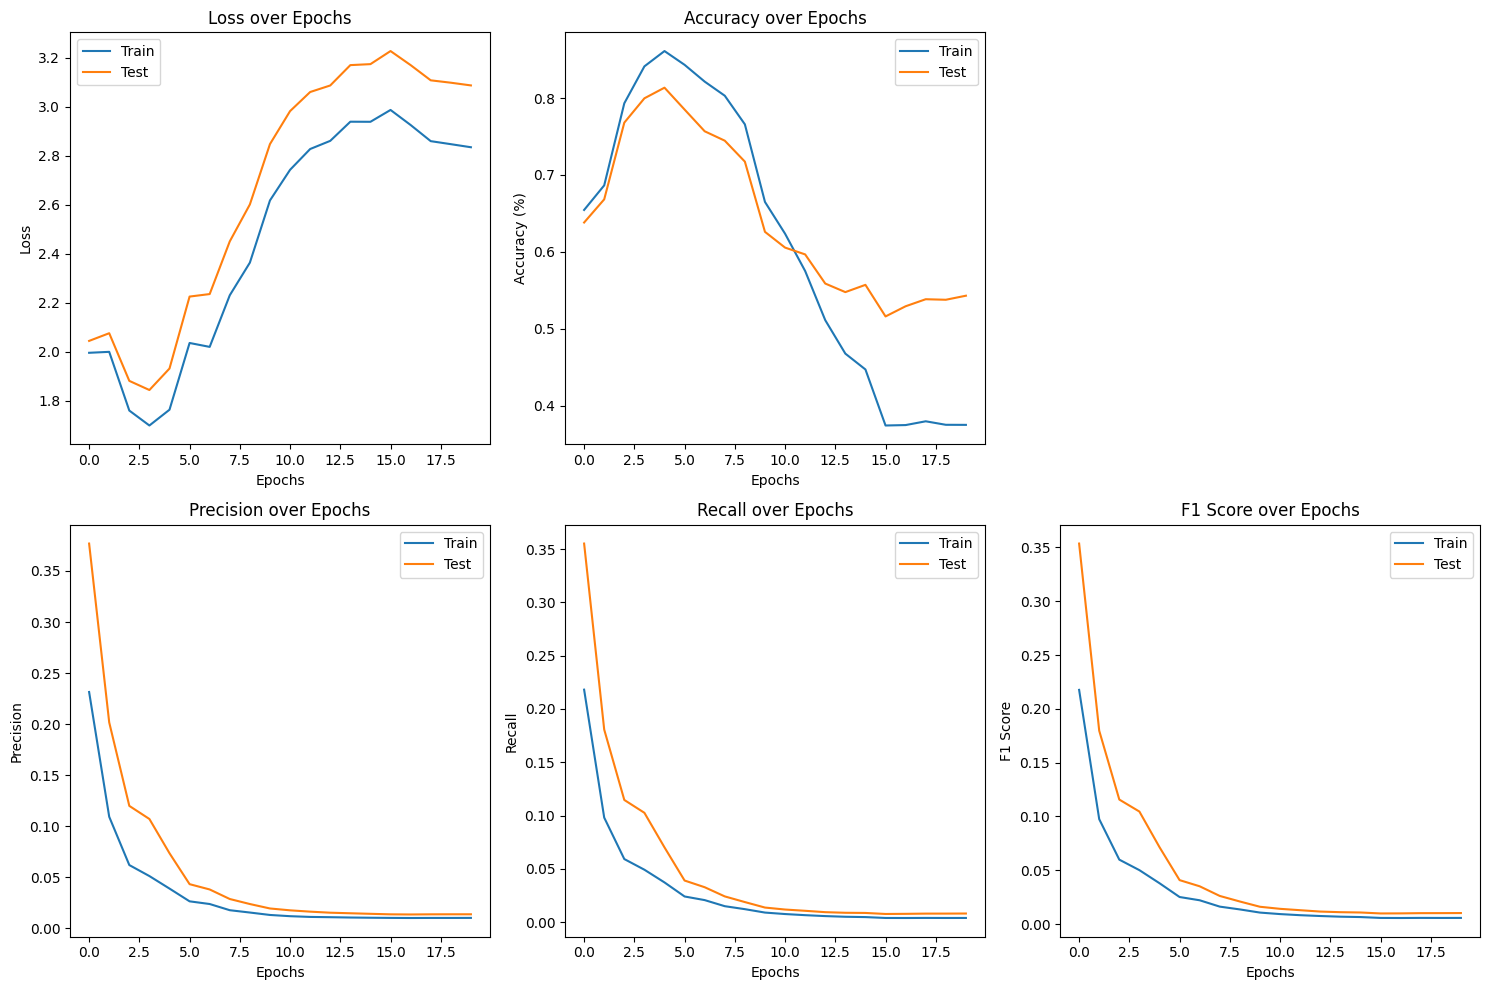

In [20]:
# Plotting
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 4)
plt.plot(train_precisions, label='Train')
plt.plot(test_precisions, label='Test')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 5)
plt.plot(train_recalls, label='Train')
plt.plot(test_recalls, label='Test')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1 Score
plt.subplot(2, 3, 6)
plt.plot(train_f1s, label='Train')
plt.plot(test_f1s, label='Test')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
